In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from toolz import concat
from scipy.spatial.distance import pdist, squareform
from aging.plotting import format_plots, PlotConfig, save_factory, figure
from aging.behavior.pseudotime import compute_pseudotime, pseudotime_springplot

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "pseudotime", tight_layout=False)
c.save_path

PosixPath('/n/groups/datta/win/figures/ontogeny')

In [3]:
version = 8  # arhmm version

df = pd.read_parquet(f'/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/ontogeny_males_clean_v2.parquet')
# df = pd.read_parquet(f'/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/ontogeny_males_clean_20mins_v1.parquet')

In [4]:
def remove_crl(df):
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [17]:
def filter_syllables(df):
    usage = df.mean()
    return df[usage[usage > 0.0025].index]

In [6]:
def zscore(df):
    return (df - df.mean()) / df.std()

In [7]:
colors = ['#DADAEB','#6A51A3']
sns.blend_palette(colors, 12)

[(0.8549019607843137, 0.8549019607843137, 0.9215686274509803),
 (0.8152864282968089, 0.8064436755094194, 0.8961014994232986),
 (0.775670895809304, 0.7579853902345252, 0.8706343713956171),
 (0.7360553633217993, 0.7095271049596309, 0.8451672433679354),
 (0.6947174163783161, 0.658961937716263, 0.8185928489042675),
 (0.6551018838908113, 0.6105036524413687, 0.7931257208765858),
 (0.6154863514033064, 0.5620453671664745, 0.7676585928489043),
 (0.5758708189158016, 0.5135870818915802, 0.7421914648212226),
 (0.5345328719723184, 0.46302191464821224, 0.7156170703575547),
 (0.49491733948481353, 0.4145636293733179, 0.6901499423298731),
 (0.45530180699730877, 0.36610534409842366, 0.6646828143021914),
 (0.41568627450980394, 0.3176470588235294, 0.6392156862745098)]

  0%|          | 0/5000 [00:00<?, ?it/s]

pseudotime_rank       age
pseudotime_rank         1.000000  0.852829
age                     0.852829  1.000000

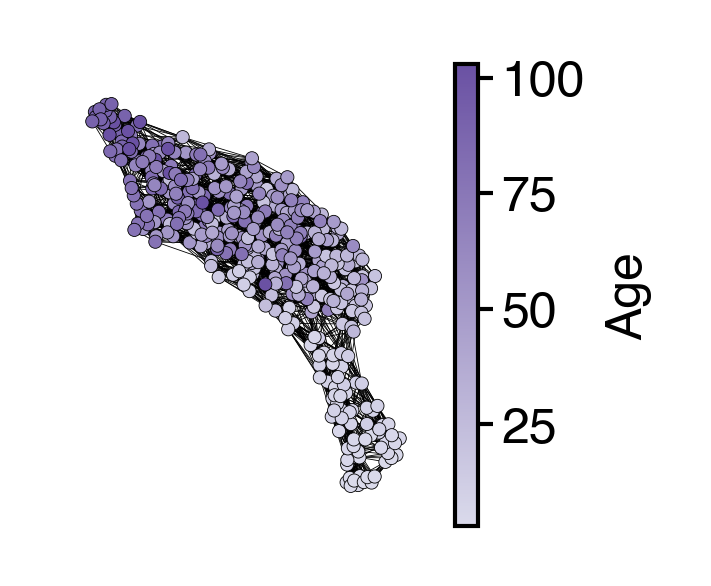

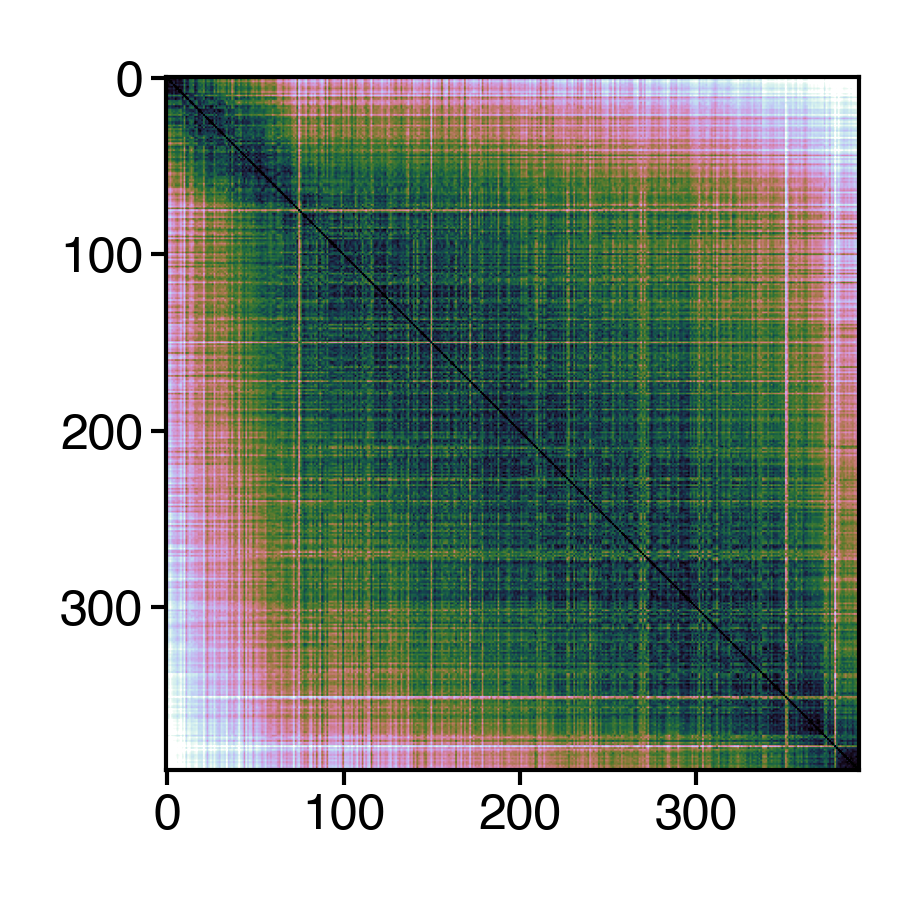

In [82]:
params = {
    "metric": "jensenshannon",
    "k_neigh": 15,
}
pseudo_df = compute_pseudotime(
    df, [remove_crl, filter_syllables], **params, initialize_w_age=True,
)

graph, pos, c, fig = pseudotime_springplot(
    df,
    [remove_crl, filter_syllables],
    # xform_fun=zscore,
    **params,
    seed=2,
    node_size=2.5,
    cmap=sns.blend_palette(colors, as_cmap=True),
)
# saver(fig, "pseudotime-ontogeny-spring-20mins");
# saver(fig, "pseudotime-male-ontogeny-spring");

figure(1.5, 1.5)
d = squareform(
        pdist(
            df.iloc[np.argsort(pseudo_df.pseudotime_rank.values)],
            metric="jensenshannon",
        )
    )
plt.imshow(
    d,
    vmin=0.15,
    vmax=0.6,
    cmap="cubehelix",
)

pseudo_df.reset_index().loc[:, ["pseudotime_rank", "age"]].corr(method="spearman")

In [43]:
# find out how many neighbors to maximize sorting smoothness
n_sessions = 25

smoothness = {}
traces = {}
ds = {}

for k in range(2, 40):
    params = {
        "metric": "jensenshannon",
        "k_neigh": k,
    }
    pseudo_df = compute_pseudotime(
        df,
        [remove_crl, filter_syllables],
        **params,
        initialize_w_age=True,
        diffusion_iter=10_000
    )

    d = squareform(
        pdist(
            df.iloc[np.argsort(pseudo_df.pseudotime_rank.values)],
            metric="jensenshannon",
        )
    )
    ds[k] = d

    rot_d = np.rot90(d, 1)
    diags = [np.diag(rot_d, i) for i in range(-n_sessions, n_sessions)]
    total = min([len(d) for d in diags]) // 2

    combined_diags = [diag[len(diag) // 2 - total : len(diag) // 2] for diag in diags]
    combined_diags = np.array(combined_diags)
    combined_diags = np.where(combined_diags == 0, np.nan, combined_diags)
    traces[k] = np.nanmean(combined_diags, axis=0)
    derivs = pd.Series(traces[k]).diff(3).dropna()
    smoothness[k] = np.std(derivs)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

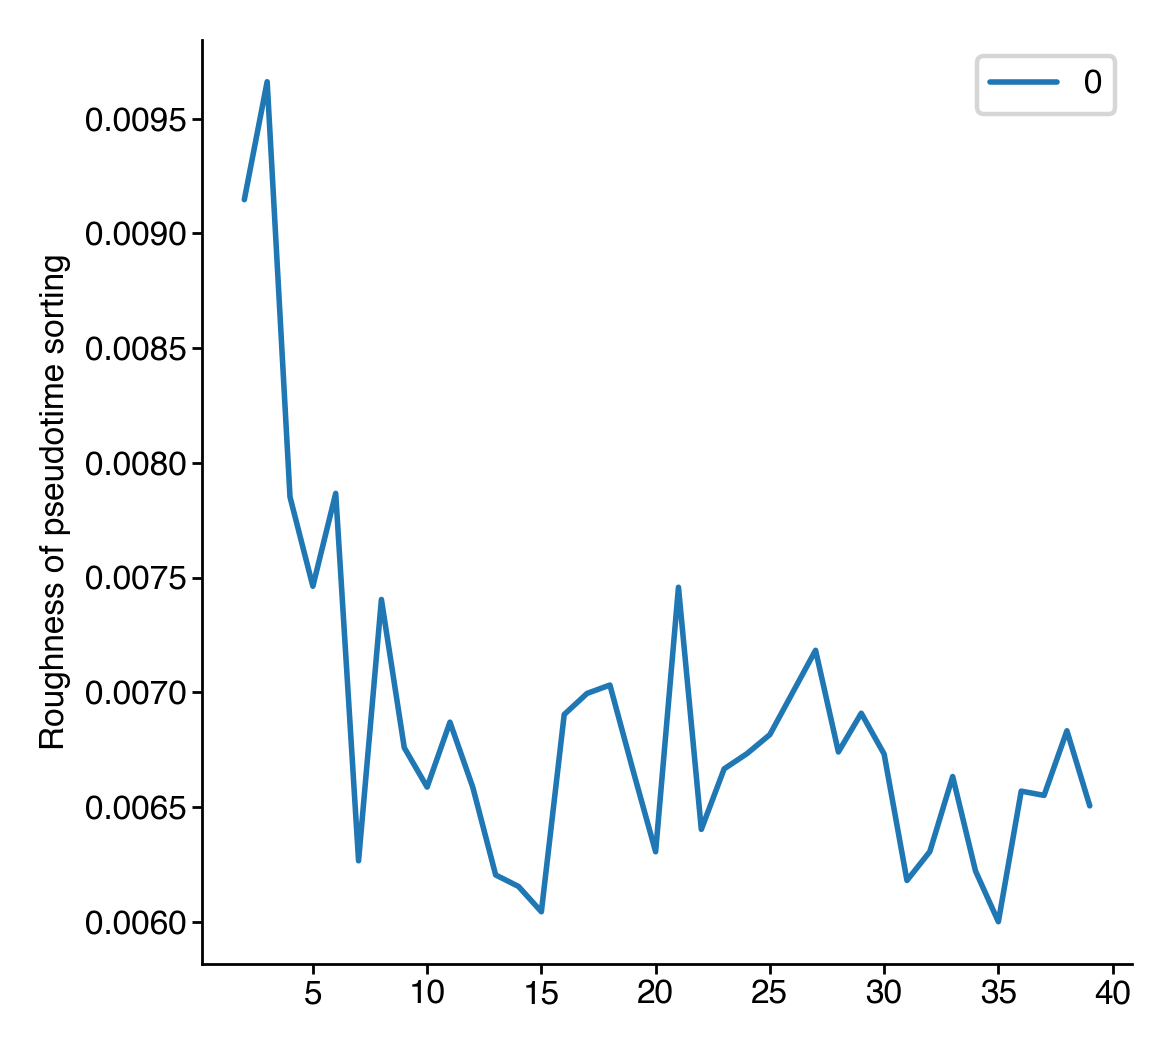

In [44]:
ax = pd.DataFrame(smoothness, index=[0]).T.plot()
ax.set(ylabel="Roughness of pseudotime sorting")
sns.despine()

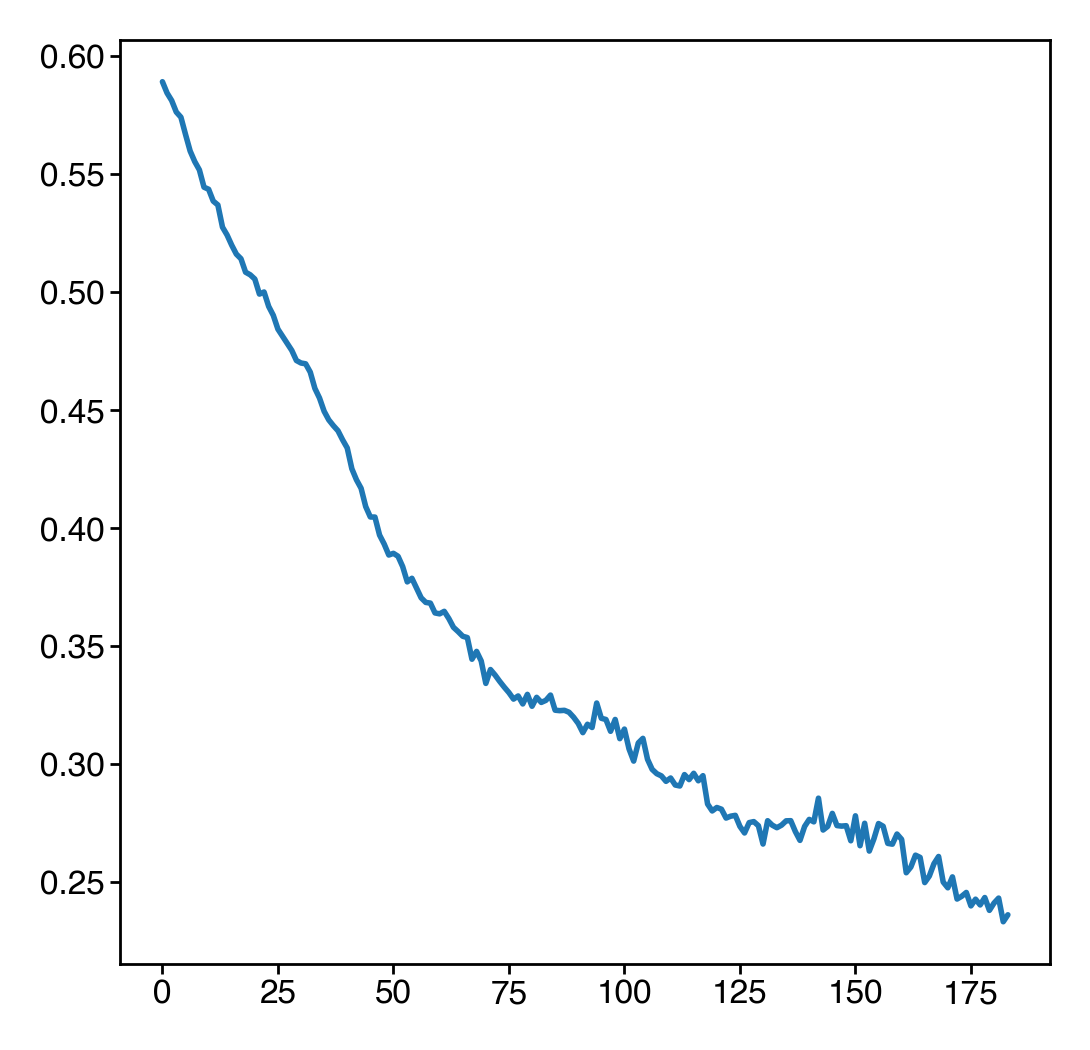

In [11]:
plt.plot(traces[15])

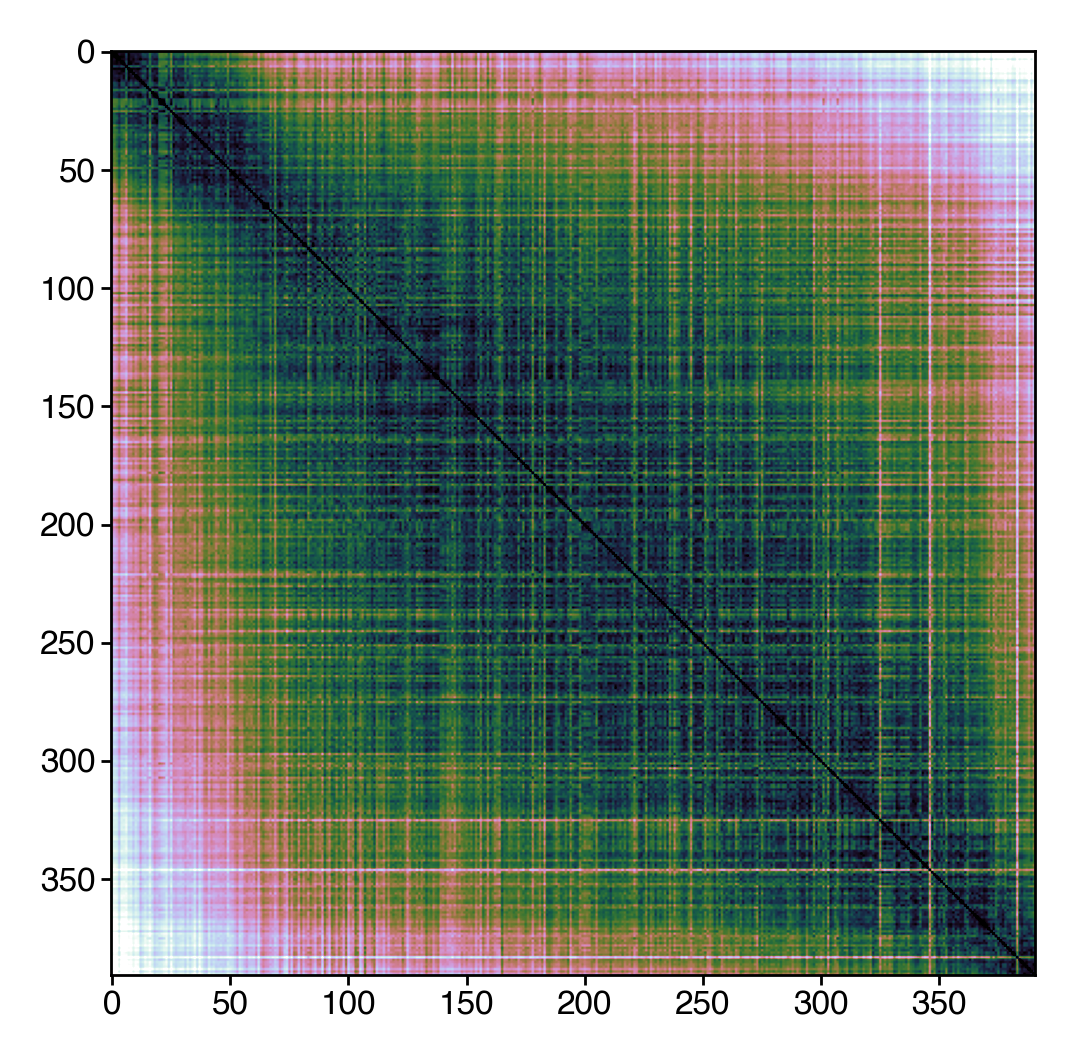

In [84]:
plt.imshow(ds[15], vmin=0.15, vmax=0.6, cmap="cubehelix")

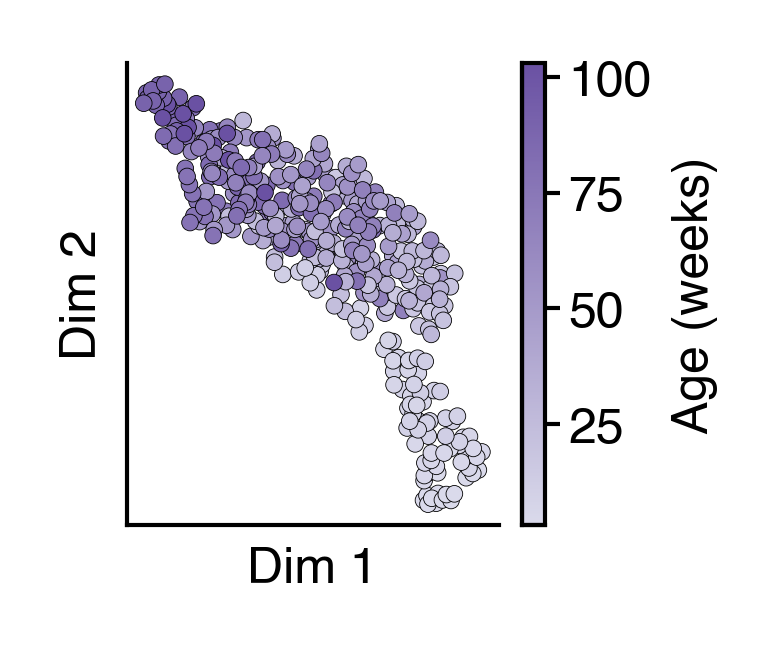

In [83]:
scatter_pos = np.array(list(pos.values()))

fig = figure(1, 1)
ax = fig.gca()
im = ax.scatter(
    *scatter_pos.T,
    c=c,
    cmap=sns.blend_palette(colors, as_cmap=True),
    s=4,
    lw=0.1,
    ec='k',
    # rasterized=True,
)
ax.set(xticks=[], yticks=[], xlabel="Dim 1", ylabel="Dim 2")
cb = fig.colorbar(im, ax=ax, label="Age (weeks)")
# cb.set_ticks(np.arange(10, 111, 10, dtype='int'))
sns.despine()
saver(fig, "pseudotime-male-ontogeny");

In [72]:
merged_df = df.join(pseudo_df)

In [73]:
merged_df = merged_df.sort_values(by='pseudotime_rank')

In [74]:
all_ages = merged_df.index.get_level_values('age').value_counts().sort_index()

In [75]:
merged_df['pseudo_age'] = list(concat([x] * v for x, v in all_ages.items()))

In [76]:
merged_df.set_index(['pseudotime_rank', 'pseudotime_dist', 'pseudo_age'], append=True, inplace=True)

In [77]:
merged_df.to_parquet(f'/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/ontogeny_males_clean_pseudotime_v02.parquet')
# merged_df.to_parquet(f'/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/ontogeny_males_clean_pseudotime_20mins_v02.parquet')

In [78]:
from sklearn.cross_decomposition import PLSRegression

In [79]:
mdl = PLSRegression(n_components=5)
x = remove_crl(merged_df)
y = x.index.get_level_values('pseudotime_rank')
x = x.filter(regex=r'\d')
mdl.fit(x, y)
mdl.score(x, y)

0.9662878263375532

In [80]:
mdl = PLSRegression(n_components=5)
x = remove_crl(merged_df)
y = x.index.get_level_values('age')
x = x.filter(regex=r'\d')
mdl.fit(x, y)
mdl.score(x, y)

0.8589926962394878